In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from utils import *

In [2]:
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=9)

train_data = gen.get_full_data_set(training=True)
test_data = gen.get_full_data_set(training=False)

In [3]:
train_data[0].shape, test_data[0].shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)
(28, 28, 1)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1


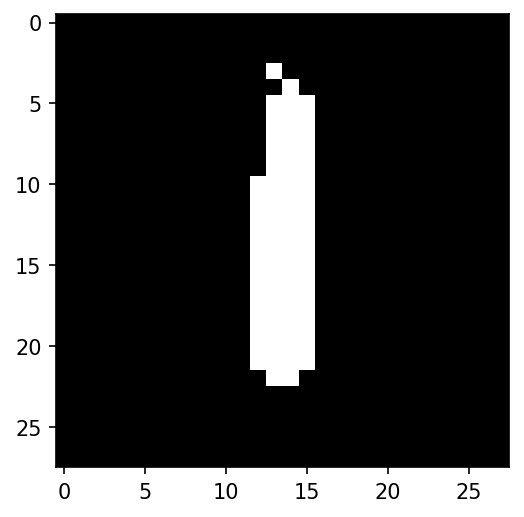

In [4]:
x_train, y_train = train_data
x_test, y_test = test_data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Convert y_train and y_test into one-hot vectors
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)

rand = np.random.randint(0, x_train.shape[0])
img = x_train[rand]
label = y_train[rand]
print(img.shape)

print(label)
print(label.argmax())
plt.figure(figsize=(6, 4), dpi=150)
plt.imshow(img, cmap="gray")

In [5]:
# Create pytorch dataloaders from x_train and y_train
x_train = torch.from_numpy(x_train.astype(np.float32)).permute(0, 3, 1, 2)
y_train = torch.from_numpy(y_train.astype(np.float32))

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

In [6]:
# Training setup
model = AutoEncoder(in_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

# Training the autoencoder

for epoch in range(50):
    model.train()
    total_loss = 0
    for images, _ in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader)}")

    # Test on test data
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            output = model(images)
            loss = criterion(output, images)
            test_loss += loss.item()
        print(f"Test Loss: {test_loss / len(test_loader)}")



Epoch: 0, Loss: 0.17258749486605326
Test Loss: 0.11047243583983125


KeyboardInterrupt: 

In [ ]:
# Save the AutoEncoder model
torch.save(model.state_dict(), "trained_models/auto_encoder.pt")

In [ ]:
# Test the auto encoder
model.eval()

test_loss = 0

with torch.no_grad():
    for x, _ in test_loader:
        pred = model(x)
        loss = criterion(pred, x)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader)}")

Test Loss: 0.0003284663547287238


In [ ]:
mnist_classifier = MNISTClassifier(1)
mnist_classifier.load_state_dict(torch.load('trained_models/mnist_model.pt'))

<All keys matched successfully>

In [ ]:
correct_preds = 0

with torch.no_grad():
    for x, y in test_loader:
        ae_output = model(x)

        ae_output_class = mnist_classifier(ae_output)
        ae_output_class = ae_output_class.argmax(dim=1, keepdim=True)
        truth = y.argmax(dim=1, keepdim=True)

        correct_preds += ae_output_class.eq(truth.view_as(ae_output_class)).sum().item()

    accuracy = correct_preds / len(test_loader.dataset)

print(f"Accuracy: {100*accuracy}%")

Accuracy: 98.9%
